In [ ]:
import os
import yaml
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from captum.attr import IntegratedGradients
from math import ceil
import numpy as np
from models.UTAELightning import UTAELightning
from dataloader.FireSpreadDataModule import FireSpreadDataModule

# === CONFIGURATION ===
CHECKPOINT_PATH = "checkpoints_variants/fold10_seed42_weather/last.ckpt"
FOLD = 10
CONFIG_PATH = "cfgs/data_monotemporal_full_features.yaml"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N_MC_SAMPLES = 20


# FEATURE_NAMES = [
#     'Precipitation',
#     'Wind speed',
#     'Wind direction',
#     'Minimum temperature',
#     'Maximum temperature',
#     'Energy release component',
#     'Specific humidity',
#     'Forecast: Total precipitation',
#     'Forecast: Wind speed',
#     'Forecast: Wind direction',
#     'Forecast: Temperature',
#     'Forecast: Specific humidity'
# ]

# === LOAD UTAE MODEL ===
model = UTAELightning.load_from_checkpoint(CHECKPOINT_PATH).to(DEVICE)
model.train()  # Enable dropout

with open(CONFIG_PATH) as f:
    data_config = yaml.safe_load(f)

    
data_config.update({
    "data_fold_id": FOLD,
    "n_leading_observations": 5,
    "n_leading_observations_test_adjustment": 5,
    "return_doy": True,
    "features_to_keep": [5, 6, 7, 8, 9, 10, 11, 17, 18, 19, 20, 21, 22, 39] ,
})


# data_config.update({
#     "data_fold_id": FOLD,
#     "n_leading_observations": 5,
#     "n_leading_observations_test_adjustment": 5,
#     "return_doy": True,
#     "features_to_keep": [16, 22, 39] ,
# })


# data_config.update({
#     "data_fold_id": FOLD,
#     "n_leading_observations": 5,
#     "n_leading_observations_test_adjustment": 5,
#     "return_doy": True,
#     "features_to_keep":[0, 1, 2, 3, 4, 38, 39],
# })

dm = FireSpreadDataModule(**data_config)
dm.setup("test")
test_loader = dm.test_dataloader()

In [ ]:
# === COLLECT TRAINING DATA ===
x_list, y_list, pred_list = [], [], []
max_fire_count = 0
max_fire_index = (0, 0)  # (batch_idx, sample_idx)


for batch_idx, (x, y, doys) in enumerate(tqdm(test_loader, desc="Collecting data")):
    x, doys = x.to(DEVICE), doys.to(DEVICE)

    with torch.no_grad():
        preds = [model(x, doys).sigmoid().cpu() for _ in range(N_MC_SAMPLES)]
    preds = torch.stack(preds, dim=0)                 # [20, B, 1, H, W]
    mean_pred = preds.mean(0).cpu()                   # Store on CPU

    x_last = x[:, -1, :-1].cpu()                      # [B, C, H, W]
    y_cpu = y.cpu()

    x_list.append(x_last)
    y_list.append(y_cpu)
    pred_list.append(mean_pred)

    for i in range(y_cpu.shape[0]):
        fire_pixels = y_cpu[i].sum().item()
        if fire_pixels > max_fire_count:
            max_fire_count = fire_pixels
            max_fire_index = (batch_idx, i)

In [ ]:
# === STACK COLLECTED DATA SAFELY ===

# 1. Find smallest height and width
min_H = min(t.shape[2] for t in x_list)
min_W = min(t.shape[3] for t in x_list)

def center_crop(tensor, h, w):
    _, _, H, W = tensor.shape
    top = (H - h) // 2
    left = (W - w) // 2
    return tensor[:, :, top:top + h, left:left + w]

X_all = torch.cat([center_crop(t, min_H, min_W) for t in x_list], dim=0)
Y_all = torch.cat([center_crop(t.unsqueeze(1), min_H, min_W).squeeze(1) for t in y_list], dim=0)
P_all = torch.cat([center_crop(t, min_H, min_W) for t in pred_list], dim=0)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from torchvision.models import resnet18
# === PREPARE DATASET FOR BATCH TRAINING ===
BATCH_SIZE = 8
train_dataset = TensorDataset(X_all, P_all)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# === DEFINE RESNET SURROGATE ===
class ResNetSurrogate(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.encoder = resnet18(weights=None)
        self.encoder.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.encoder.fc = nn.Identity()
        
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),  # 9x6 → 18x12
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 18x12 → 36x24
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 36x24 → 72x48
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # 72x48 → 144x96
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, 2, 1),    # 144x96 → 288x192
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=1)         # Final output [B, 1, 288, 192]
        )


    def forward(self, x):
        x = self.encoder.conv1(x)
        x = self.encoder.bn1(x)
        x = self.encoder.relu(x)
        x = self.encoder.maxpool(x)
        x = self.encoder.layer1(x)
        x = self.encoder.layer2(x)
        x = self.encoder.layer3(x)
        x = self.encoder.layer4(x)
        return self.decoder(x)
        

surrogate = ResNetSurrogate(X_all.shape[1]).to(DEVICE)
optimizer = torch.optim.Adam(surrogate.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# === TRAIN SURROGATE WITH MINI-BATCHES ===
for epoch in range(50):
    surrogate.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        pred = surrogate(xb)
        assert pred.shape == yb.shape, f"Mismatch: pred={pred.shape}, yb={yb.shape}"

        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    avg_loss = epoch_loss / len(train_dataset)
    print(f"Epoch {epoch}: Loss {avg_loss:.4f}")

# === WRAP FOR IG ===
class SurrogateMeanWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        return self.model(x).mean(dim=[1, 2, 3])  # scalar per input

wrapped_surrogate = SurrogateMeanWrapper(surrogate).to(DEVICE).eval()

# === RUN IG ON BEST SAMPLE ===
batch_idx, sample_idx = max_fire_index
x_best = x_list[batch_idx][sample_idx:sample_idx+1].to(DEVICE).requires_grad_()
mean_pred_best = pred_list[batch_idx][sample_idx, 0]
fire_gt_best = y_list[batch_idx][sample_idx]

ig = IntegratedGradients(wrapped_surrogate)
attr = ig.attribute(x_best, n_steps=50)
attr = attr.squeeze(0).detach().cpu()  # [C, H, W]

In [ ]:
from sklearn.metrics import r2_score

surrogate.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb = xb.to(DEVICE)
        pred = surrogate(xb).cpu().flatten()
        target = yb.cpu().flatten()
        all_preds.append(pred)
        all_targets.append(target)

# Concatenate and compute R²
preds_flat = torch.cat(all_preds).numpy()
targets_flat = torch.cat(all_targets).numpy()
r2 = r2_score(targets_flat, preds_flat)

print(f"\n🔍 Surrogate model R²: {r2:.4f}")

In [ ]:
import torch
import matplotlib.pyplot as plt

# === INPUT ===
# attr should be [C, H, W], already computed using IG on the selected sample


FEATURE_NAMES = [
    'Precipitation',
    'Wind speed',
    'Wind direction',
    'Minimum temperature',
    'Maximum temperature',
    'Energy release component',
    'Specific humidity',
    'Forecast: Total precipitation',
    'Forecast: Wind speed',
    'Forecast: Wind direction',
    'Forecast: Temperature',
    'Forecast: Specific humidity',
    'Active fire'
]

# FEATURE_NAMES = [
#     'Landcover',
#     'Active fire'
# ]

# FEATURE_NAMES = ["VIIRS_M11", "VIIRS_I2", "VIIRS_I1", "NDVI", "EVI2", 'Active fire']

# FEATURE_NAMES = ["Slope", "Aspect", "Elevation",'Active fire']

# FEATURE_NAMES = ["VIIRS_M11", "VIIRS_I2", "VIIRS_I1", "NDVI", "EVI2",'Precipitation',
#     'Wind speed',
#     'Wind direction',
#     'Minimum temperature',
#     'Maximum temperature',
#     'Energy release component',
#     'Specific humidity',
#     'Forecast: Total precipitation',
#     'Forecast: Wind speed',
#     'Forecast: Wind direction',
#     'Forecast: Temperature',
#     'Forecast: Specific humidity',
#     'Active fire','Landcover',
#                 ]

assert attr.ndim == 3, "Expected attr to be of shape [C, H, W]"

# === COMPUTE IMPORTANCE SCORES ===
importance_scores = attr.abs().mean(dim=[1, 2])  # [C]

# === NORMALIZE TO PERCENTAGE ===
importance_pct = 100 * importance_scores / importance_scores.sum()

# === PRINT RESULTS ===
print("=== Integrated Gradients Feature Importance ===")
for i, name in enumerate(FEATURE_NAMES):
    print(f"{name:10s}: {importance_pct[i]:5.2f}% of total attribution")

# === PLOT BAR CHART ===
plt.figure(figsize=(10, 6))  # Slightly larger for more breathing room
plt.bar(FEATURE_NAMES, importance_pct.numpy(), color='royalblue')
plt.xlabel("Input Feature", fontsize=15)
plt.ylabel("Attribution %", fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=13)  # Tilt and right-align
plt.yticks(fontsize=13)
plt.tight_layout()
#plt.savefig("attr_importance_barplot-vegetation.png", dpi=300)
plt.show()


In [ ]:
from captum.attr import IntegratedGradients
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# === WRAP MODEL FOR IG ===
class SurrogateMeanWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        return self.model(x).mean(dim=[1, 2, 3])

wrapped_surrogate = SurrogateMeanWrapper(surrogate).to(DEVICE).eval()
ig = IntegratedGradients(wrapped_surrogate)

# === Compute Global Attribution Over Test Set ===
total_attr = torch.zeros(X_all.shape[1])  # [C]
total_samples = 0

for xb, _ in tqdm(train_loader, desc="Global IG attribution"):
    xb = xb.to(DEVICE).requires_grad_()
    attr = ig.attribute(xb, n_steps=50)
    attr = attr.abs().mean(dim=[0, 2, 3]).cpu()  # [C]
    total_attr += attr
    total_samples += 1

importance_pct = 100 * total_attr / total_attr.sum()

# === Plot Attribution ===
plt.figure(figsize=(10, 6))
plt.bar(FEATURE_NAMES, importance_pct.numpy(), color='royalblue')
plt.xlabel("Input Feature", fontsize=15)
plt.ylabel("Attribution %", fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.savefig("global_ig_attribution.png", dpi=300)
plt.show()


In [ ]:
from captum.attr import IntegratedGradients
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import autocast

# === WRAP MODEL FOR IG ===
class SurrogateMeanWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        return self.model(x).mean(dim=[1, 2, 3])

wrapped_surrogate = SurrogateMeanWrapper(surrogate).to(DEVICE).eval()
ig = IntegratedGradients(wrapped_surrogate)

# === Compute Global Attribution Over Test Set ===
total_attr = torch.zeros(X_all.shape[1])  # [C]
total_samples = 0

for xb, _ in tqdm(train_loader, desc="Global IG attribution"):
    xb = xb.to(DEVICE).requires_grad_()
    with autocast():
        attr = ig.attribute(xb, n_steps=20)  # Reduced from 50 to 20
    attr = attr.abs().mean(dim=[0, 2, 3]).cpu()  # [C]
    total_attr += attr
    total_samples += 1

importance_pct = 100 * total_attr / total_attr.sum()

In [ ]:

# === Plot Attribution ===
plt.figure(figsize=(10, 6))
plt.bar(FEATURE_NAMES, importance_pct.detach().numpy(), color='royalblue')
plt.xlabel("Input Feature", fontsize=15)
plt.ylabel("Attribution %", fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.savefig("global_ig_attribution-vegetation.png", dpi=300)
plt.show()

In [ ]:
from tqdm import tqdm

# === COLLECT DATA FROM FIRST HALF OF TEST LOADER ===
x_list, y_list, pred_list = [], [], []
max_fire_count = 0
best_sample = None


for batch_idx, (x, y, doys) in enumerate(tqdm(test_loader, desc="Scanning for largest fire in first half")):

    fire_counts = y.view(y.shape[0], -1).sum(dim=1)  # [B]
    max_in_batch = fire_counts.max().item()

    if max_in_batch > max_fire_count:
        max_fire_count = max_in_batch
        idx = fire_counts.argmax().item()

        best_sample = {
            "x": x[idx:idx+1],         # Keep batch dimension: [1, ...]
            "y": y[idx],               # [H, W]
            "doys": doys[idx:idx+1],   # Keep batch dimension: [1, ...]
            "batch_num": batch_idx,
            "sample_idx": idx
        }

assert best_sample is not None, "No fire samples found in first half of test set."
print(f"🔥 Largest fire (first half) in batch {best_sample['batch_num']}, sample {best_sample['sample_idx']}, fire_pixels={int(max_fire_count)}")

In [ ]:
# Step 2: Run MC Dropout for that sample
x = best_sample["x"].to(DEVICE)
doys = best_sample["doys"].to(DEVICE)
y = best_sample["y"]  # still on CPU

preds = []
with torch.no_grad():
    for _ in range(N_MC_SAMPLES):
        out = model(x, doys).sigmoid()
        preds.append(out)

preds = torch.stack(preds, dim=0)  # [T, B, 1, H, W]
mean_pred = preds.mean(dim=0)[0, 0]  # [H, W]
var_pred = preds.var(dim=0)[0, 0]
eps = 1e-8
entropy_pred = -(mean_pred * (mean_pred + eps).log() + (1 - mean_pred) * (1 - mean_pred + eps).log())

In [ ]:
import matplotlib.cm as cm
import numpy as np

# === UQ Overlay on feature of interest + Mean Prediction ===


ndvi_idx = 4
ndvi_img = best_sample["x"][0, -1, ndvi_idx].cpu().numpy()
mean_img = mean_pred.cpu().numpy()
overlay = entropy_pred.cpu().numpy()
overlay_clipped = np.clip(overlay, 0.05, None)
gt_mask = y.cpu().numpy()

# Use vibrant colormap
uq_cmap = cm.get_cmap('turbo').copy()
uq_cmap.set_under('none')

# Plot
fig, axs = plt.subplots(1, 4, figsize=(22, 6))

# Panel 1: NDVI only
axs[0].imshow(ndvi_img, cmap='Greens_r')
axs[0].set_title("--", fontsize=11)
axs[0].axis('off')

# Panel 2: Entropy overlay on NDVI + GT contour
axs[1].imshow(ndvi_img, cmap='bone')
im2 = axs[1].imshow(overlay_clipped, cmap=uq_cmap, alpha=0.6, vmin=0.05)
axs[1].contour(gt_mask, colors='cyan', linewidths=1.0)
axs[1].set_title("Entropy Overlay on NDVI", fontsize=11)
axs[1].axis('off')

# Panel 3: Mean Prediction
axs[2].imshow(mean_img, cmap='gray')
axs[2].set_title("Mean Prediction", fontsize=11)
axs[2].axis('off')

# Panel 4: Ground Truth
axs[3].imshow(gt_mask, cmap='gray', vmin=0, vmax=1)
axs[3].set_title("Ground Truth", fontsize=11)
axs[3].axis('off')

# Colorbar for entropy
cbar_ax2 = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cbar2 = fig.colorbar(im2, cax=cbar_ax2)
cbar2.set_label("Entropy", fontsize=10)

# === Save ===
fig.tight_layout(rect=[0, 0, 0.92, 1])
fig.canvas.draw()

# base_name = f"entropy_weather_mean_gt_batch{best_sample['batch_num']}_sample{best_sample['sample_idx']}"
# png_path = os.path.join(SAVE_DIR, f"{base_name}.png")
# fig.savefig(png_path, dpi=300, bbox_inches='tight', format='png')
# plt.show()

# print(f"✅ Saved 4-panel figure as PNG: {png_path}")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

SAVE_DIR = "uq_largest_fire_overlay"
# === Extract images ===
ndvi_idx = 4
ndvi_img = best_sample["x"][0, -1, ndvi_idx].cpu().numpy()
mean_img = mean_pred.cpu().numpy()
overlay = entropy_pred.cpu().numpy()
overlay_clipped = np.clip(overlay, 0.05, None)
gt_mask = y.cpu().numpy()

# === Compute crop bounds around GT mask ===
coords = np.argwhere(gt_mask > 0)
y_min, x_min = coords.min(axis=0)
y_max, x_max = coords.max(axis=0)
pad = 30
y_min = max(0, y_min - pad)
y_max = min(gt_mask.shape[0], y_max + pad)
x_min = max(0, x_min - pad)
x_max = min(gt_mask.shape[1], x_max + pad)

# === Crop all panels ===
ndvi_crop = ndvi_img[y_min:y_max, x_min:x_max]
overlay_crop = overlay_clipped[y_min:y_max, x_min:x_max]
mean_crop = mean_img[y_min:y_max, x_min:x_max]
gt_crop = gt_mask[y_min:y_max, x_min:x_max]

# === Set colormap ===
uq_cmap = cm.get_cmap('turbo').copy()
uq_cmap.set_under('none')

# === Plot ===
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

fs=20
# Panel 1: Entropy only
im2 = axs[0].imshow(overlay_crop, cmap=uq_cmap, vmin=0.05)
axs[0].contour(gt_crop, colors='cyan', linewidths=1.0)
axs[0].set_title("Entropy Overlay", fontsize=fs)
axs[0].axis('off')

# Panel 2: Mean Prediction
axs[1].imshow(mean_crop, cmap='gray')
axs[1].set_title("Mean Prediction", fontsize=fs)
axs[1].axis('off')

# Panel 3: Ground Truth
axs[2].imshow(gt_crop, cmap='gray', vmin=0, vmax=1)
axs[2].set_title("Ground Truth", fontsize=fs)
axs[2].axis('off')

# Colorbar
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label("Entropy", fontsize=fs)

# Final adjustments
fig.tight_layout(rect=[0, 0, 0.92, 1])
fig.canvas.draw()

base_name = f"entropy_weather_mean_gt_batch{best_sample['batch_num']}_sample{best_sample['sample_idx']}"
png_path = os.path.join(SAVE_DIR, f"{base_name}.png")
fig.savefig(png_path, dpi=300, bbox_inches='tight', format='png')
plt.show()

print(f"✅ Saved 4-panel figure as PNG: {png_path}")


In [ ]:
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
import os

# === Crop all panels ===
ndvi_crop = ndvi_img[y_min:y_max, x_min:x_max]  # unused, kept for context
overlay_crop = overlay_clipped[y_min:y_max, x_min:x_max]
mean_crop = mean_img[y_min:y_max, x_min:x_max]
gt_crop = gt_mask[y_min:y_max, x_min:x_max]

# === Error map ===
error_map = (mean_crop > 0.95).astype(int) - gt_crop  # -1: FN, +1: FP, 0: correct

# === Set colormap ===
uq_cmap = cm.get_cmap('turbo').copy()
uq_cmap.set_under('none')

# === Plot ===
fig, axs = plt.subplots(1, 4, figsize=(22, 6))
fs = 20

# Panel 1: Entropy only
im0 = axs[0].imshow(overlay_crop, cmap=uq_cmap, vmin=0.05)
axs[0].contour(gt_crop, colors='cyan', linewidths=1.0)
axs[0].set_title("Entropy Overlay", fontsize=fs)
axs[0].axis('off')

# Panel 2: Mean Prediction
axs[1].imshow(mean_crop, cmap='gray')
axs[1].set_title("Mean Prediction", fontsize=fs)
axs[1].axis('off')

# Panel 3: Ground Truth
axs[2].imshow(gt_crop, cmap='gray', vmin=0, vmax=1)
axs[2].set_title("Ground Truth", fontsize=fs)
axs[2].axis('off')

# Panel 4: Prediction Error
axs[3].imshow(error_map, cmap='bwr', vmin=-1, vmax=1)
axs[3].set_title("Prediction Error", fontsize=fs)
axs[3].axis('off')

# Colorbar for entropy
cbar_ax = fig.add_axes([0.94, 0.15, 0.01, 0.7])
cbar = fig.colorbar(im0, cax=cbar_ax)
cbar.set_label("Entropy", fontsize=fs)

# Final adjustments
fig.tight_layout(rect=[0, 0, 0.93, 1])
fig.canvas.draw()

# Save
base_name = f"entropy_mean_gt_error_batch{best_sample['batch_num']}_sample{best_sample['sample_idx']}"
png_path = os.path.join(SAVE_DIR, f"{base_name}.png")
fig.savefig(png_path, dpi=300, bbox_inches='tight', format='png')
plt.show()

print(f"✅ Saved 4-panel figure as PNG: {png_path}")


In [ ]:
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

# === Crop all panels ===
ndvi_crop = ndvi_img[y_min:y_max, x_min:x_max]  # unused
overlay_crop = overlay_clipped[y_min:y_max, x_min:x_max]
mean_crop = mean_img[y_min:y_max, x_min:x_max]
gt_crop = gt_mask[y_min:y_max, x_min:x_max]

# === Error map ===
pred_binary = (mean_crop > 0.95).astype(np.int32)
gt_crop_int = gt_crop.astype(np.int32)
error_map = pred_binary - gt_crop_int  # Now values will be: -1 (FN), 0 (correct), +1 (FP)

error_map = np.clip(error_map, -1, 1)


# === Set colormap ===
uq_cmap = cm.get_cmap('turbo').copy()
uq_cmap.set_under('none')

# === Plot ===
fig, axs = plt.subplots(1, 4, figsize=(22, 6))
fs = 20

# Colorbar for entropy (LEFT side)
cbar_ax = fig.add_axes([0.01, 0.15, 0.01, 0.7])

# Panel 1: Entropy
im0 = axs[0].imshow(overlay_crop, cmap=uq_cmap, vmin=0.05)
axs[0].contour(gt_crop, colors='cyan', linewidths=1.0)
axs[0].set_title("Entropy Overlay", fontsize=fs)
axs[0].axis('off')

# Colorbar linked to entropy
cbar = fig.colorbar(im0, cax=cbar_ax)
cbar.set_label("Entropy", fontsize=fs)

# Panel 2: Mean Prediction
axs[1].imshow(mean_crop, cmap='gray')
axs[1].set_title("Mean Prediction", fontsize=fs)
axs[1].axis('off')

# Panel 3: Ground Truth
axs[2].imshow(gt_crop, cmap='gray', vmin=0, vmax=1)
axs[2].set_title("Ground Truth", fontsize=fs)
axs[2].axis('off')

# Panel 4: Prediction Error
im_err = axs[3].imshow(error_map, cmap='bwr', vmin=-1, vmax=1)
axs[3].set_title("Prediction Error", fontsize=fs)
axs[3].axis('off')

# Custom legend for prediction error
legend_patches = [
    mpatches.Patch(color='blue', label='False Negative (-1)'),
    mpatches.Patch(color='white', label='Correct (0)', edgecolor='gray', linewidth=0.5),
    mpatches.Patch(color='red', label='False Positive (+1)')
]
axs[3].legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=fs-4)

# Final adjustments
fig.tight_layout(rect=[0.05, 0, 0.92, 1])  # leave room for colorbar on left and legend on right
fig.canvas.draw()

# Save
base_name = f"entropy_mean_gt_error_batch{best_sample['batch_num']}_sample{best_sample['sample_idx']}"
png_path = os.path.join(SAVE_DIR, f"{base_name}.png")
fig.savefig(png_path, dpi=300, bbox_inches='tight', format='png')
plt.show()

print(f"✅ Saved 4-panel figure as PNG: {png_path}")

In [ ]:
N_MC_SAMPLES = 20
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CROP_SIZE = 128
ENTROPY_THRESHOLD = 0.2
PRED_THRESHOLD = 0.95
SAVE_DIR = "entropy_error_heatmaps"
os.makedirs(SAVE_DIR, exist_ok=True)
CROP_SIZE = 128

In [ ]:
from scipy.ndimage import distance_transform_edt, center_of_mass
# === LOAD MODEL WITH MC DROPOUT ===
model = UTAELightning.load_from_checkpoint(CHECKPOINT_PATH).to(DEVICE)
model.train()

# === AGGREGATION ARRAYS ===
H, W = CROP_SIZE, CROP_SIZE
entropy_sum = np.zeros((H, W))
fp_sum = np.zeros((H, W))
fn_sum = np.zeros((H, W))
tp_sum = np.zeros((H, W))
count_map = np.zeros((H, W))

# === HELPER: crop centered around GT fireline ===
def crop_centered(img, center_y, center_x, size):
    half = size // 2
    y_min = max(center_y - half, 0)
    x_min = max(center_x - half, 0)
    y_max = y_min + size
    x_max = x_min + size
    return img[y_min:y_max, x_min:x_max]
o
# === INFERENCE + AGGREGATION ===
print("[INFO] Running inference and accumulating heatmaps...")

for batch_idx, (x, y, doys) in enumerate(tqdm(test_loader, desc="Fold 10")):
    x, doys = x.to(DEVICE), doys.to(DEVICE)

    with torch.no_grad():
        preds = [model(x, doys).sigmoid().detach().cpu() for _ in range(N_MC_SAMPLES)]
    preds = torch.stack(preds, dim=0)  # [N, B, 1, H, W]
    mean_pred = preds.mean(0)[:, 0].numpy()
    entropy = -(mean_pred * np.log(mean_pred + 1e-8) + (1 - mean_pred) * np.log(1 - mean_pred + 1e-8))
    gt = (y == 1).cpu().numpy()

    for i in range(mean_pred.shape[0]):
        gt_mask = gt[i]
        pred_binary = (mean_pred[i] > PRED_THRESHOLD).astype(np.int32)
        entropy_map = entropy[i]
        error_map = np.clip(pred_binary - gt_mask.astype(np.int32), -1, 1)

        # center crop around GT fire centroid
        if np.sum(gt_mask) == 0:
            continue
        cy, cx = center_of_mass(gt_mask)
        cy, cx = int(cy), int(cx)

        ent_crop = crop_centered(entropy_map, cy, cx, CROP_SIZE)
        err_crop = crop_centered(error_map, cy, cx, CROP_SIZE)
        pred_crop = crop_centered(pred_binary, cy, cx, CROP_SIZE)
        gt_crop = crop_centered(gt_mask, cy, cx, CROP_SIZE)

        if ent_crop.shape != (H, W):
            continue  # skip edge cases

        # accumulate
        entropy_sum += ent_crop
        fp_sum += (err_crop == 1)
        fn_sum += (err_crop == -1)
        tp_sum += (pred_crop & gt_crop)
        count_map += 1

# === AVERAGE HEATMAPS ===
mean_entropy = entropy_sum / np.clip(count_map, 1, None)
fp_rate = fp_sum / np.clip(count_map, 1, None)
fn_rate = fn_sum / np.clip(count_map, 1, None)
tp_rate = tp_sum / np.clip(count_map, 1, None)


In [ ]:

# === PLOT ===
def plot_heatmap(data, title, fname, cmap='inferno'):
    plt.figure(figsize=(6, 6))
    plt.imshow(data, cmap=cmap)
    plt.colorbar()
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, fname), dpi=300)
    plt.close()

plot_heatmap(mean_entropy, "Mean Predictive Entropy", "mean_entropy.png")
plot_heatmap(fp_rate, "False Positive Rate", "fp_rate.png", cmap='Reds')
plot_heatmap(fn_rate, "False Negative Rate", "fn_rate.png", cmap='Blues')
plot_heatmap(tp_rate, "True Positive Rate", "tp_rate.png", cmap='Greens')

print(f"[INFO] Saved all heatmaps to: {SAVE_DIR}/")

In [ ]:
# 🧠 Step-by-Step: Radial Quantification Pipeline
# ✅ Step 1: Create a Distance Map (in meters)
    
H, W = mean_entropy.shape
PIXEL_SIZE_M = 20  # adjust to match your data
Y, X = np.ogrid[:H, :W]
cy, cx = H // 2, W // 2
dist_map = np.sqrt((Y - cy)**2 + (X - cx)**2) * PIXEL_SIZE_M

In [ ]:
bins = np.arange(0, 300 + 10, 10)  # 0 to 300 meters, step 10
bin_centers = (bins[:-1] + bins[1:]) / 2


In [ ]:
fpr_radial = []
entropy_radial = []

for i in range(len(bins) - 1):
    mask = (dist_map >= bins[i]) & (dist_map < bins[i+1])
    fpr_radial.append(fp_rate[mask].mean())
    entropy_radial.append(mean_entropy[mask].mean())


In [ ]:
fp_total = np.sum(fp_rate)
fp_cumsum = []
for i in range(len(bins) - 1):
    mask = dist_map < bins[i+1]
    fp_cumsum.append(np.sum(fp_rate[mask]) / fp_total)

In [ ]:
for r, c in zip(bins[1:], fp_cumsum):
    if c >= 0.80:
        print(f"80% of FPs within {r} meters")
        break

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(bin_centers, fpr_radial, label="False Positive Rate", color='red')
plt.plot(bin_centers, entropy_radial, label="Entropy", color='purple')
plt.axvline(0, color='black', linestyle='--', label="Fire center")
plt.xlabel("Distance from fire center (meters)", fontsize=13)
plt.ylabel("Mean value", fontsize=13)
plt.title("Radial Profile of FPR and Entropy", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "radial_profile_fpr_entropy.png"), dpi=300)
plt.show()


In [ ]:

# === AVERAGE HEATMAPS ===
mean_entropy = entropy_sum / np.clip(count_map, 1, None)
fp_rate = fp_sum / np.clip(count_map, 1, None)

# === DISTANCE MAP ===
Y, X = np.ogrid[:H, :W]
cy, cx = H // 2, W // 2
dist_map = np.sqrt((Y - cy)**2 + (X - cx)**2) * PIXEL_SIZE_M

# === RADIAL BINNING ===
MAX_DISTANCE_M = 300
BIN_WIDTH = 10
bins = np.arange(0, MAX_DISTANCE_M + BIN_WIDTH, BIN_WIDTH)
bin_centers = (bins[:-1] + bins[1:]) / 2

fpr_radial = []
entropy_radial = []

for i in range(len(bins) - 1):
    mask = (dist_map >= bins[i]) & (dist_map < bins[i+1])
    if np.any(mask):
        fpr_radial.append(fp_rate[mask].mean())
        entropy_radial.append(mean_entropy[mask].mean())
    else:
        fpr_radial.append(np.nan)
        entropy_radial.append(np.nan)

# === FP containment zone
fp_total = np.sum(fp_rate)
fp_cumsum = []
for i in range(len(bins) - 1):
    mask = dist_map < bins[i+1]
    fp_cumsum.append(np.sum(fp_rate[mask]) / fp_total)

containment_radius = None
for r, c in zip(bins[1:], fp_cumsum):
    if c >= 0.80:
        containment_radius = r
        print(f"✅ 80% of FPs are within {r} meters.")
        break

# === Plot
plt.figure(figsize=(8, 5))
plt.plot(bin_centers, fpr_radial, label="False Positive Rate", color='red')
plt.plot(bin_centers, entropy_radial, label="Entropy", color='purple')
plt.axvline(0, color='black', linestyle='--', label="Fire center")

if containment_radius is not None:
    plt.axvline(containment_radius, color='gray', linestyle=':',
                label=f"80% FP within {containment_radius}m")

plt.xlabel("Distance from fire center (meters)", fontsize=13)
plt.ylabel("Mean value", fontsize=13)
plt.title("Radial Profile of FPR and Entropy", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "radial_profile_fpr_entropy.png"), dpi=300)
plt.show()

In [ ]:
# do the same for deep ensembles and compare 

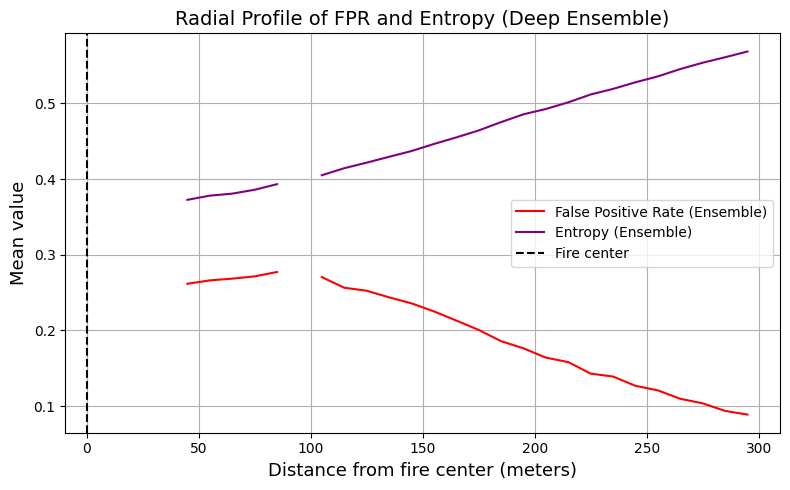

In [1]:
# import os
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # === LOAD FILES ===
# SAVE_DIR = "gt_radial_analysis_ensemble"
# npz_data = np.load(os.path.join(SAVE_DIR, "ensemble_radial_data.npz"))
# radial_df = pd.read_parquet(os.path.join(SAVE_DIR, "ensemble_radial_metrics.parquet"))

# # === UNPACK DATA ===
# mean_entropy = npz_data["mean_entropy"]
# fp_rate = npz_data["fp_rate"]
# dist_map = npz_data["dist_map"]

# bin_centers = radial_df["distance_m"]
# fpr_radial = radial_df["fpr_radial"]
# entropy_radial = radial_df["entropy_radial"]
# fp_cumsum = radial_df["fp_cumsum"]

# # === FIND CONTAINMENT RADIUS ===
# containment_radius = None
# bins = np.arange(0, 300 + 10, 10)  # must match original binning
# for r, c in zip(bins[1:], fp_cumsum):
#     if c >= 0.80:
#         containment_radius = r
#         break

# # === PLOT ===
# plt.figure(figsize=(8, 5))
# plt.plot(bin_centers, fpr_radial, label="False Positive Rate (Ensemble)", color='red')
# plt.plot(bin_centers, entropy_radial, label="Entropy (Ensemble)", color='purple')
# plt.axvline(0, color='black', linestyle='--', label="Fire center")
# if containment_radius is not None:
#     plt.axvline(containment_radius, color='gray', linestyle=':',
#                 label=f"80% FP within {containment_radius}m")
# plt.xlabel("Distance from fire center (meters)", fontsize=13)
# plt.ylabel("Mean value", fontsize=13)
# plt.title("Radial Profile of FPR and Entropy (Deep Ensemble)", fontsize=14)
# plt.legend()
# plt.grid(True)
# plt.tight_layout()



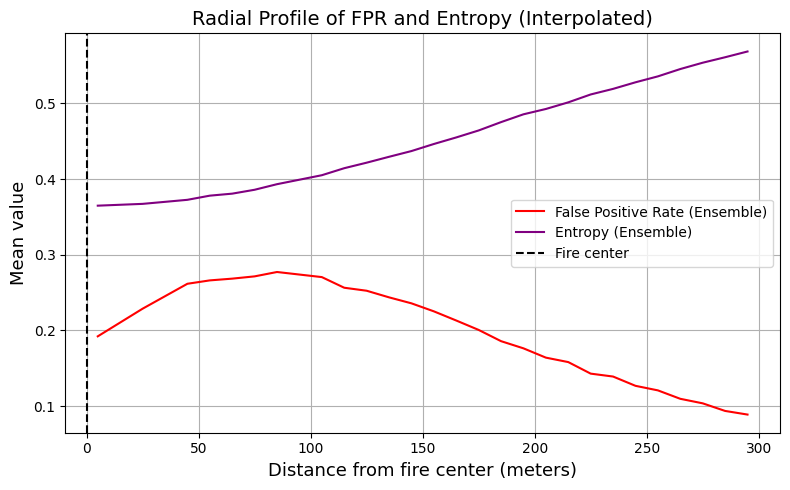

In [4]:
# Interpolate missing values (NaNs)
df=pd.read_parquet(os.path.join(SAVE_DIR, "ensemble_radial_metrics.parquet"))
df_interp = df.copy()
df_interp["fpr_radial"] = df["fpr_radial"].interpolate(method="linear", limit_direction="both")
df_interp["entropy_radial"] = df["entropy_radial"].interpolate(method="linear", limit_direction="both")

# Plot the interpolated version
plt.figure(figsize=(8, 5))
plt.plot(df["distance_m"], df_interp["fpr_radial"], label="False Positive Rate (Ensemble)", color='red')
plt.plot(df["distance_m"], df_interp["entropy_radial"], label="Entropy (Ensemble)", color='purple')
plt.axvline(0, color='black', linestyle='--', label="Fire center")
plt.xlabel("Distance from fire center (meters)", fontsize=13)
plt.ylabel("Mean value", fontsize=13)
plt.title("Radial Profile of FPR and Entropy (Interpolated)", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()

In [5]:
original_parquet = os.path.join(SAVE_DIR, "ensemble_radial_metrics.parquet")
original_npz = os.path.join(SAVE_DIR, "ensemble_radial_data.npz")
new_parquet = os.path.join(SAVE_DIR, "ensemble_radial_metrics_interpolated.parquet")
new_npz = os.path.join(SAVE_DIR, "ensemble_radial_data_interpolated.npz")

# === LOAD ORIGINAL FILES ===
df = pd.read_parquet(original_parquet)
npz_data = np.load(original_npz)

# === INTERPOLATE NaNs LINEARLY ===
df_interp = df.copy()
df_interp["fpr_radial"] = df["fpr_radial"].interpolate(method="linear", limit_direction="both")
df_interp["entropy_radial"] = df["entropy_radial"].interpolate(method="linear", limit_direction="both")
df_interp["fp_cumsum"] = df["fp_cumsum"].interpolate(method="linear", limit_direction="both")

# === SAVE NEW PARQUET ===
df_interp.to_parquet(new_parquet, index=False)

# === SAVE NEW NPZ ===
np.savez_compressed(
    new_npz,
    mean_entropy=npz_data["mean_entropy"],
    fp_rate=npz_data["fp_rate"],
    dist_map=npz_data["dist_map"]
)

print(f"✅ Interpolated data saved to:\n- {new_parquet}\n- {new_npz}")

✅ Interpolated data saved to:
- gt_radial_analysis_ensemble/ensemble_radial_metrics_interpolated.parquet
- gt_radial_analysis_ensemble/ensemble_radial_data_interpolated.npz


Using the following dataset split:
Train years: [2020, 2021], Val years: [2018], Test years: [2019]
[INFO] Computing boundary distances from ensemble models...


100%|███████████████████████████████████████████████████████████████████████████████| 1055/1055 [13:23<00:00,  1.31it/s]


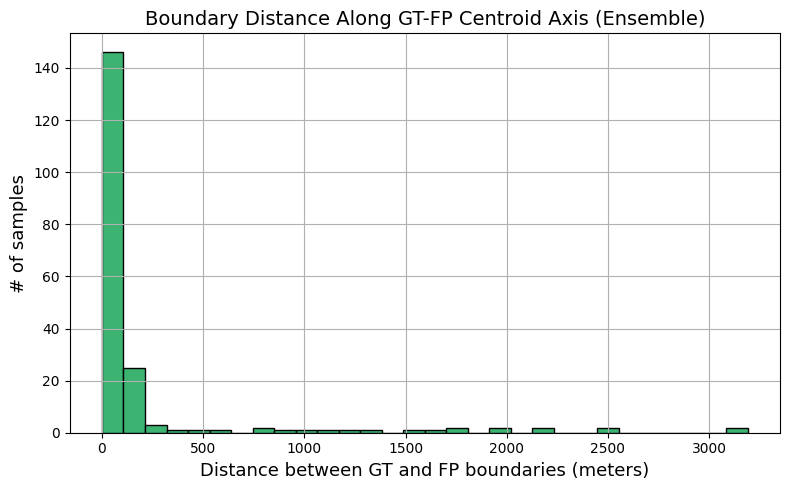

[INFO] Saved boundary gap distances to: centroid_axis_buffer_ensemble/


In [17]:
import os
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import binary_dilation, center_of_mass
from skimage.draw import line
from models.UTAELightning import UTAELightning
from dataloader.FireSpreadDataModule import FireSpreadDataModule

# === CONFIGURATION ===
ENSEMBLE_PATHS = [
    "checkpoints/ensemble_fold10_seed1337/last.ckpt",
    "checkpoints/ensemble_fold10_seed2024/last.ckpt",
    "checkpoints/ensemble_fold10_seed31415/last.ckpt",
    "checkpoints/ensemble_fold10_seed42/last.ckpt",
    "checkpoints/ensemble_fold10_seed777/last.ckpt"
]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIXEL_SIZE_M = 20
PRED_THRESHOLD = 0.95
SAVE_DIR = "centroid_axis_buffer_ensemble"
os.makedirs(SAVE_DIR, exist_ok=True)

# === LOAD DATA ===
with open("cfgs/data_monotemporal_full_features.yaml", "r") as f:
    data_config = yaml.safe_load(f)
data_config.update({
    "data_fold_id": 10,
    "n_leading_observations": 5,
    "n_leading_observations_test_adjustment": 5,
    "return_doy": True,
    "features_to_keep": [0, 1, 2, 3, 4, 38, 39],
})
dm = FireSpreadDataModule(**data_config)
dm.setup("test")
test_loader = dm.test_dataloader()

# === ENSEMBLE INFERENCE ===
boundary_gap_distances = []

print("[INFO] Computing boundary distances from ensemble models...")
for batch_idx, (x, y, doys) in enumerate(tqdm(test_loader)):
    x, doys = x.to(DEVICE), doys.to(DEVICE)

    ensemble_preds = []
    for path in ENSEMBLE_PATHS:
        model = UTAELightning.load_from_checkpoint(path).to(DEVICE)
        model.eval()
        with torch.no_grad():
            pred = model(x, doys).sigmoid().detach().cpu()
        ensemble_preds.append(pred)

    preds = torch.stack(ensemble_preds, dim=0)  # [E, B, 1, H, W]
    mean_pred = preds.mean(0)[:, 0].numpy()
    gt = (y == 1).cpu().numpy()

    for i in range(mean_pred.shape[0]):
        gt_mask = gt[i].astype(np.uint8)
        if np.sum(gt_mask) == 0:
            continue

        pred_binary = (mean_pred[i] > PRED_THRESHOLD).astype(np.uint8)
        fp_mask = (pred_binary == 1) & (gt_mask == 0)

        if np.sum(fp_mask) == 0:
            continue

        cy_gt, cx_gt = center_of_mass(gt_mask)
        cy_fp, cx_fp = center_of_mass(fp_mask)
        cy_gt, cx_gt = int(cy_gt), int(cx_gt)
        cy_fp, cx_fp = int(cy_fp), int(cx_fp)

        rr, cc = line(cy_gt, cx_gt, cy_fp, cx_fp)
        rr, cc = np.clip(rr, 0, gt_mask.shape[0] - 1), np.clip(cc, 0, gt_mask.shape[1] - 1)

        gt_edge = binary_dilation(gt_mask) & (~gt_mask)
        fp_edge = binary_dilation(fp_mask) & (~fp_mask)

        for yx in zip(rr, cc):
            y, x = yx
            if gt_edge[y, x]:
                gt_point = np.array([y, x])
                break
        else:
            continue

        for yx in zip(reversed(rr), reversed(cc)):
            y, x = yx
            if fp_edge[y, x]:
                fp_point = np.array([y, x])
                break
        else:
            continue

        distance_pix = np.linalg.norm(fp_point - gt_point)
        distance_m = distance_pix * PIXEL_SIZE_M
        boundary_gap_distances.append(distance_m)

# === PLOT HISTOGRAM ===
plt.figure(figsize=(8, 5))
plt.hist(boundary_gap_distances, bins=30, color='mediumseagreen', edgecolor='black')
plt.xlabel("Distance between GT and FP boundaries (meters)", fontsize=13)
plt.ylabel("# of samples", fontsize=13)
plt.title("Boundary Distance Along GT-FP Centroid Axis (Ensemble)", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "boundary_distance_hist_ensemble.png"), dpi=300)
plt.show()

# === SAVE DATA ===
np.savez_compressed(
    os.path.join(SAVE_DIR, "boundary_gap_distances_ensemble.npz"),
    distances=np.array(boundary_gap_distances)
)
print(f"[INFO] Saved boundary gap distances to: {SAVE_DIR}/")


In [19]:
import os
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import binary_dilation, center_of_mass
from skimage.draw import line

from models.UTAELightning import UTAELightning
from dataloader.FireSpreadDataModule import FireSpreadDataModule

# === CONFIG ===
BASE_CHECKPOINT_DIR = "/mnt/c/Users/chakr/WildfireSpreadTS/checkpoints_variants"
VARIANTS = [
    "fold10_seed42_landcover",
    "fold10_seed42_topography",
    "fold10_seed42_vegetation",
    "fold10_seed42_weather"
]
SAVE_DIR = "centroid_axis_buffer_variants"
os.makedirs(SAVE_DIR, exist_ok=True)

PIXEL_SIZE_M = 20
PRED_THRESHOLD = 0.95
N_MC_SAMPLES = 20
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

FEATURE_SETS = {
    "vegetation": [0, 1, 2, 3, 4, 38, 39],
    "weather": [5, 6, 7, 8, 9, 10, 11, 17, 18, 19, 20, 21, 22, 39],
    "topography": [12, 13, 14, 22, 39],
    "landcover": [16, 22, 39]
}

# === MAIN LOOP FOR VARIANTS ===
for variant in VARIANTS:
    variant_type = variant.split('_')[-1]
    print(f"\n[INFO] Processing: {variant}")

    # === Load and modify config per variant ===
    with open("cfgs/data_monotemporal_full_features.yaml", "r") as f:
        data_config = yaml.safe_load(f)
    data_config.update({
        "data_fold_id": 10,
        "n_leading_observations": 5,
        "n_leading_observations_test_adjustment": 5,
        "return_doy": True,
        "features_to_keep": FEATURE_SETS[variant_type],
    })

    dm = FireSpreadDataModule(**data_config)
    dm.setup("test")
    test_loader = dm.test_dataloader()

    # === Load model ===
    checkpoint_path = os.path.join(BASE_CHECKPOINT_DIR, variant, "last.ckpt")
    model = UTAELightning.load_from_checkpoint(checkpoint_path).to(DEVICE)
    model.train()

    boundary_gap_distances = []

    for batch_idx, (x, y, doys) in enumerate(tqdm(test_loader, desc=variant)):
        x, doys = x.to(DEVICE), doys.to(DEVICE)

        with torch.no_grad():
            preds = [model(x, doys).sigmoid().detach().cpu() for _ in range(N_MC_SAMPLES)]
        preds = torch.stack(preds, dim=0)
        mean_pred = preds.mean(0)[:, 0].numpy()
        gt = (y == 1).cpu().numpy()

        for i in range(mean_pred.shape[0]):
            gt_mask = gt[i].astype(np.uint8)
            if np.sum(gt_mask) == 0:
                continue

            pred_binary = (mean_pred[i] > PRED_THRESHOLD).astype(np.uint8)
            fp_mask = (pred_binary == 1) & (gt_mask == 0)
            if np.sum(fp_mask) == 0:
                continue

            cy_gt, cx_gt = center_of_mass(gt_mask)
            cy_fp, cx_fp = center_of_mass(fp_mask)
            cy_gt, cx_gt = int(cy_gt), int(cx_gt)
            cy_fp, cx_fp = int(cy_fp), int(cx_fp)

            rr, cc = line(cy_gt, cx_gt, cy_fp, cx_fp)
            rr, cc = np.clip(rr, 0, gt_mask.shape[0] - 1), np.clip(cc, 0, gt_mask.shape[1] - 1)

            gt_edge = binary_dilation(gt_mask) & (~gt_mask)
            fp_edge = binary_dilation(fp_mask) & (~fp_mask)

            for yx in zip(rr, cc):
                y_pix, x_pix = yx
                if gt_edge[y_pix, x_pix]:
                    gt_point = np.array([y_pix, x_pix])
                    break
            else:
                continue

            for yx in zip(reversed(rr), reversed(cc)):
                y_pix, x_pix = yx
                if fp_edge[y_pix, x_pix]:
                    fp_point = np.array([y_pix, x_pix])
                    break
            else:
                continue

            distance_pix = np.linalg.norm(fp_point - gt_point)
            distance_m = distance_pix * PIXEL_SIZE_M
            boundary_gap_distances.append(distance_m)

    # === SAVE AS .npz ===
    save_name = f"boundary_gap_distances_{variant_type}.npz"
    save_path = os.path.join(SAVE_DIR, save_name)
    np.savez_compressed(save_path, distances=np.array(boundary_gap_distances))
    print(f"[✅] Saved {save_name} to {SAVE_DIR}/")

    # === OPTIONAL HISTOGRAM PLOT ===
    plt.figure(figsize=(8, 5))
    plt.hist(boundary_gap_distances, bins=30, color='skyblue', edgecolor='black')
    plt.xlabel("Distance between GT and FP boundaries (meters)", fontsize=13)
    plt.ylabel("# of samples", fontsize=13)
    plt.title(f"Boundary Distance Histogram ({variant_type})", fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, f"boundary_distance_hist_{variant_type}.png"), dpi=300)
    plt.close()



[INFO] Processing: fold10_seed42_landcover
Using the following dataset split:
Train years: [2020, 2021], Val years: [2018], Test years: [2019]


fold10_seed42_landcover: 100%|██████████████████████████████████████████████████████| 1055/1055 [09:05<00:00,  1.94it/s]


[✅] Saved boundary_gap_distances_landcover.npz to centroid_axis_buffer_variants/

[INFO] Processing: fold10_seed42_topography
Using the following dataset split:
Train years: [2020, 2021], Val years: [2018], Test years: [2019]


fold10_seed42_topography: 100%|█████████████████████████████████████████████████████| 1055/1055 [09:09<00:00,  1.92it/s]


[✅] Saved boundary_gap_distances_topography.npz to centroid_axis_buffer_variants/

[INFO] Processing: fold10_seed42_vegetation
Using the following dataset split:
Train years: [2020, 2021], Val years: [2018], Test years: [2019]


fold10_seed42_vegetation: 100%|█████████████████████████████████████████████████████| 1055/1055 [09:13<00:00,  1.91it/s]


[✅] Saved boundary_gap_distances_vegetation.npz to centroid_axis_buffer_variants/

[INFO] Processing: fold10_seed42_weather
Using the following dataset split:
Train years: [2020, 2021], Val years: [2018], Test years: [2019]


fold10_seed42_weather: 100%|████████████████████████████████████████████████████████| 1055/1055 [09:21<00:00,  1.88it/s]


[✅] Saved boundary_gap_distances_weather.npz to centroid_axis_buffer_variants/
